In [14]:
%load_ext autoreload
%autoreload 2
%pylab inline

from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL, poly_kernel, gauss_kernel, scoring

def plot_decision_boundaries(model, X_train, y_train,
                             X_test, y_test, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()
    dv = DecisionBoundariesVisualizer(model, classes=[0, 1, 2, 3])
    markers = next(dv.markers), next(dv.markers), next(dv.markers), next(dv.markers)
    colors = dv.colors
    dv = DecisionBoundariesVisualizer(model, classes=[-1, 1],
                                      ax=ax, step_size=0.025,
                                      show_scatter=False,
                                      pcolormesh_alpha=0.25)

    ax.scatter(*X_train[y_train==-1].T, color=colors[0],
               edgecolors='black', marker=markers[0], s=30,
               label='-train')
    ax.scatter(*X_train[y_train==1].T, color=colors[1],
               edgecolors='black', marker=markers[1], s=30,
               label='+train')
    ax.scatter(*X_test[y_test==-1].T, color=colors[2],
               edgecolors='black', marker=markers[2], s=30,
               label='-test')
    ax.scatter(*X_test[y_test==1].T, color=colors[3],
               edgecolors='black', marker=markers[3], s=30,
               label='+test')
    dv.fit_draw_poof(X_test, y_test)
    ax.legend()


def plot_kernel_importances(model, kernel_attrs, colormap):
    kernel_attrs = np.asarray(kernel_attrs)
    df = pd.DataFrame(np.c_[model.e_mu_orig, kernel_attrs],
                  columns=['e_mu', 'kernel', 'features', 'parameter'])\
       .astype({'e_mu': float, 'kernel': str,#
                'features': str, 'parameter': float})

    g = sns.FacetGrid(df, col='kernel', size=4)
    vmin, vmax = df.e_mu.min(), df.e_mu.max()
    g.map_dataframe(
        lambda data, color: sns.heatmap(
            data.pivot("parameter", "features", "e_mu"),
            vmin=vmin, vmax=vmax, cmap=colormap
        ),
    )


def evaluate_model(model, X, y, kernel_attrs, divergent_cmap='YlOrRd'):
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.2, stratify=y)

    model.fit(X_train, y_train)
    
    plot_kernel_importances(model, kernel_attrs, divergent_cmap)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    model.plot_e(rug=True, kde=True, norm_hist=True, ax=ax,
                 rug_kws={'color': 'r', 'linewidth': 2,
                          'alpha':1})
    ax.set_title(r'$e_\mu$ distplot')

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    model.plot_a(rug=True, kde=True, norm_hist=True, ax=ax,
                 rug_kws={'color': 'r', 'linewidth': 2,
                          'alpha':1})
    ax.set_title(r'$a_\mu$ distplot')
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cr = ClassificationReport(model, classes=[-1, 1], ax=ax,
                              cmap=divergent_cmap)
    cr.fit(X_train, y_train)
    cr.score(X_test, y_test)
    cr.poof()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cm = ConfusionMatrix(model, classes=[-1, 1], ax=ax,
                         cmap=divergent_cmap)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    rocauc = ROCAUC(model, classes=[-1, 1], ax=ax)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    plot_decision_boundaries(model, X_train, y_train, X_test, y_test, ax=ax)

    model_cv = clone(model)
    scoring.iteration = 0
    folds = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
    return cross_validate(model_cv, X, y, cv=folds, scoring=scoring)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


,x1,x2,y
0,-1.960879,3.274641,1
1,-3.467446,4.116827,1
2,4.502682,-4.663688,1
3,-3.168106,-3.047719,-1
4,2.316970,-2.764366,1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,0.021278,-0.011786,0.0000
std,3.134771,3.158739,1.0005
min,-7.020823,-7.192812,-1.0000
25%,-3.003967,-2.982247,-1.0000
50%,-0.065368,-0.048628,0.0000
75%,2.999135,3.046543,1.0000
max,5.891802,5.892626,1.0000


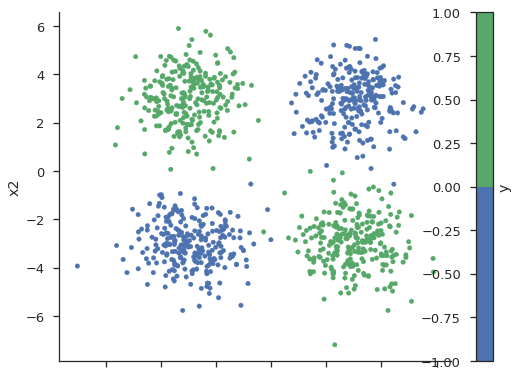

In [2]:
corner = 3
centers = [[-corner, -corner], [-corner, corner],
           [corner, -corner], [corner, corner]]
X, y = make_blobs(n_samples=N, centers=centers)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[(y==0) | (y==3)] = -1
y[y==2] = 1
data['y'] = y
display(data.head())
display(data.describe())
cmap = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
        (0.33333333333333331, 0.6588235294117647, 0.40784313725490196)]
cmap = ListedColormap(cmap)
data.plot.scatter('x1', 'x2', c='y', cmap=cmap)
sns.despine()
plt.tight_layout()

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 0, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 0, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(39, 39)

# Sparse Model

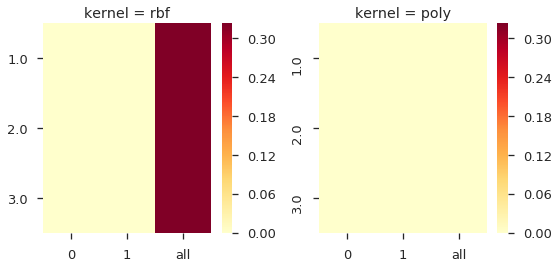

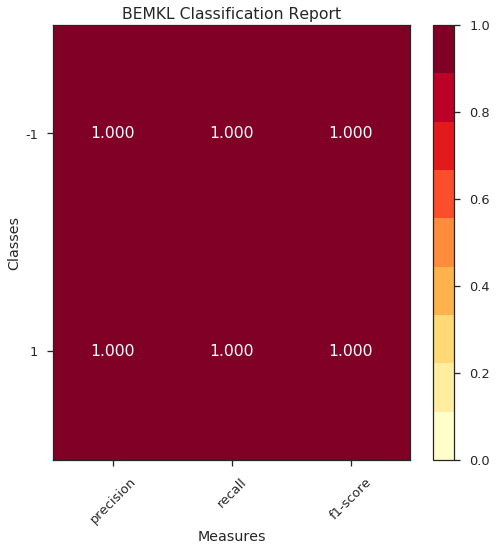

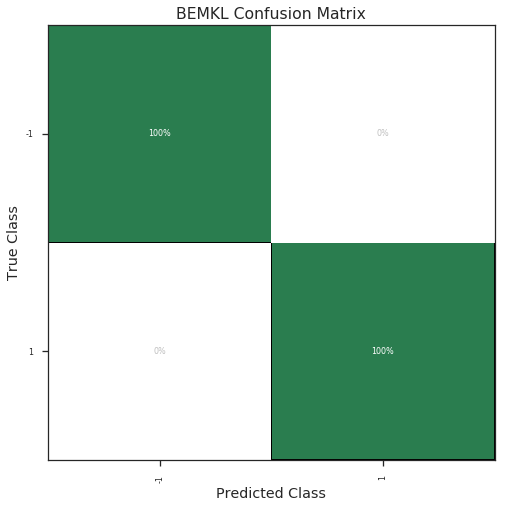

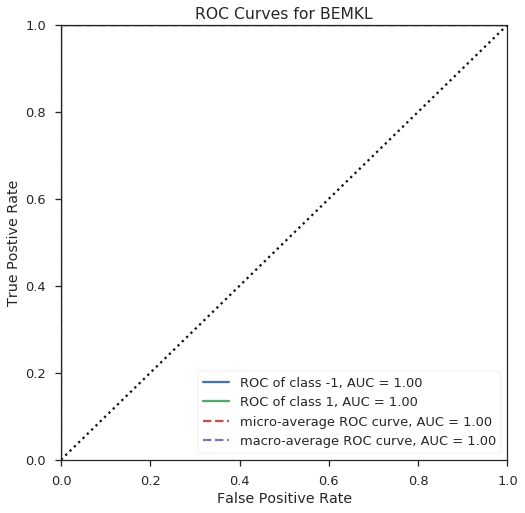

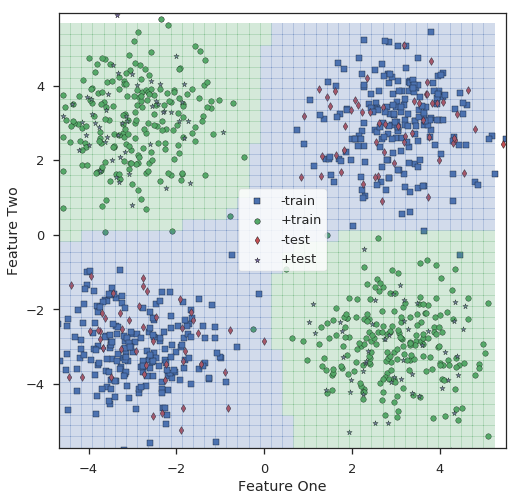

0 - Kernels: 10/39 (0.2564102564102564). SV: 665/666 (0.9984984984984985). Mean e: 0.3251. Median e: 0.3251. Std e: 0.0000. 
1 - Kernels: 10/39 (0.2564102564102564). SV: 665/666 (0.9984984984984985). Mean e: 0.3251. Median e: 0.3251. Std e: 0.0000. 
2 - Kernels: 10/39 (0.2564102564102564). SV: 661/666 (0.9924924924924925). Mean e: 0.3241. Median e: 0.3241. Std e: 0.0000. 
3 - Kernels: 10/39 (0.2564102564102564). SV: 661/666 (0.9924924924924925). Mean e: 0.3241. Median e: 0.3241. Std e: 0.0000. 
4 - Kernels: 10/39 (0.2564102564102564). SV: 657/668 (0.9835329341317365). Mean e: 0.3187. Median e: 0.3187. Std e: 0.0000. 
5 - Kernels: 10/39 (0.2564102564102564). SV: 657/668 (0.9835329341317365). Mean e: 0.3187. Median e: 0.3187. Std e: 0.0000. 
6 - Kernels: 10/39 (0.2564102564102564). SV: 665/666 (0.9984984984984985). Mean e: 0.3180. Median e: 0.3180. Std e: 0.0000. 
7 - Kernels: 10/39 (0.2564102564102564). SV: 665/666 (0.9984984984984985). Mean e: 0.3180. Median e: 0.3180. Std e: 0.0000. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 9.8669,  9.1231,  8.1058,  9.1271,  9.1315,  9.6024]),
 'score_time': array([ 0.3303,  0.3193,  0.3359,  0.3104,  0.3075,  0.3404]),
 'test_score': array([ 0.997,  0.988,  0.997,  0.994,  1.   ,  0.991]),
 'train_score': array([ 0.997 ,  0.9985,  0.9955,  0.9985,  0.9955,  0.997 ])}

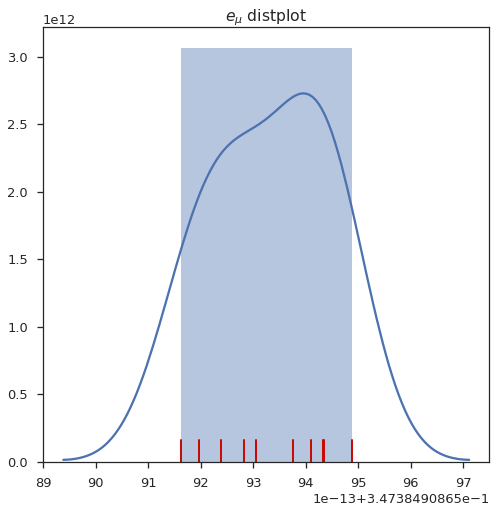

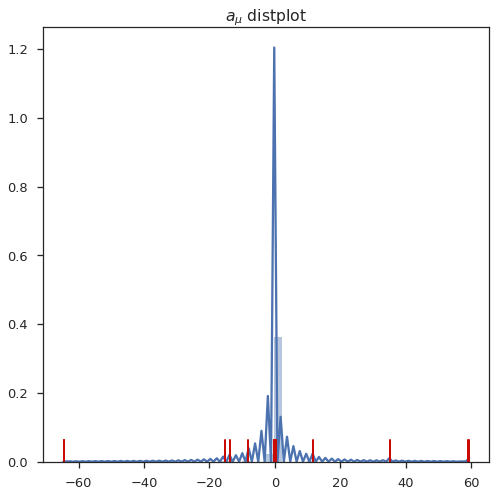

In [15]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3)
evaluate_model(sparse_model, X, y, kernel_attrs)

# Non-Sparse Model

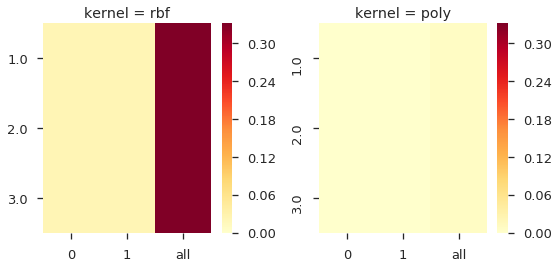

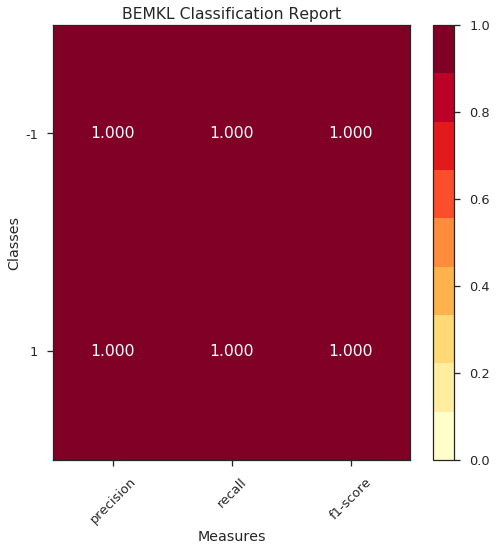

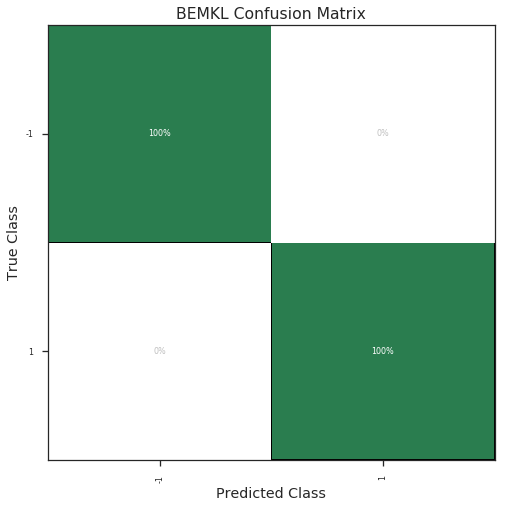

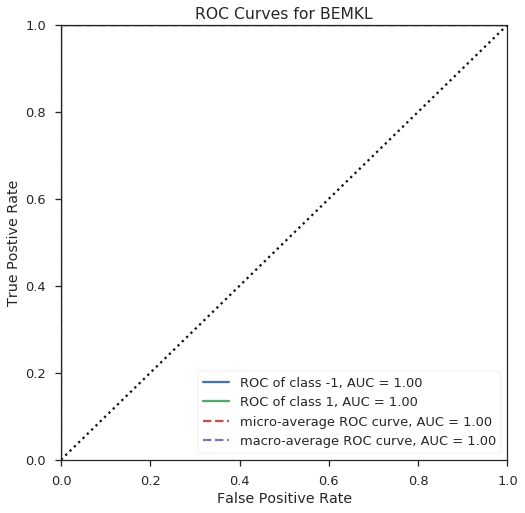

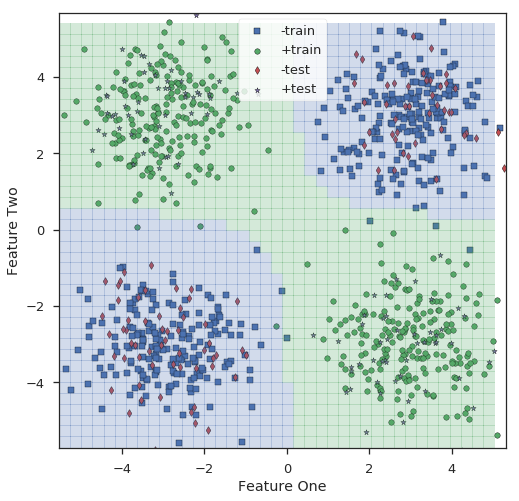

0 - Kernels: 33/39 (0.8461538461538461). SV: 657/666 (0.9864864864864865). Mean e: 0.0846. Median e: -0.0172. Std e: 0.1605. 
1 - Kernels: 33/39 (0.8461538461538461). SV: 657/666 (0.9864864864864865). Mean e: 0.0846. Median e: -0.0172. Std e: 0.1605. 
2 - Kernels: 33/39 (0.8461538461538461). SV: 661/666 (0.9924924924924925). Mean e: 0.1044. Median e: 0.0045. Std e: 0.1476. 
3 - Kernels: 33/39 (0.8461538461538461). SV: 661/666 (0.9924924924924925). Mean e: 0.1044. Median e: 0.0045. Std e: 0.1476. 
4 - Kernels: 33/39 (0.8461538461538461). SV: 665/668 (0.9955089820359282). Mean e: 0.1112. Median e: 0.0135. Std e: 0.1459. 
5 - Kernels: 33/39 (0.8461538461538461). SV: 665/668 (0.9955089820359282). Mean e: 0.1112. Median e: 0.0135. Std e: 0.1459. 
6 - Kernels: 33/39 (0.8461538461538461). SV: 662/666 (0.993993993993994). Mean e: 0.1155. Median e: 0.0148. Std e: 0.1419. 
7 - Kernels: 33/39 (0.8461538461538461). SV: 662/666 (0.993993993993994). Mean e: 0.1155. Median e: 0.0148. Std e: 0.1419. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 9.2761,  9.247 ,  7.7791,  9.4423,  9.1278,  8.0087]),
 'score_time': array([ 1.1099,  1.0341,  1.004 ,  1.0382,  1.4057,  0.8801]),
 'test_score': array([ 1.   ,  1.   ,  0.988,  1.   ,  0.994,  0.997]),
 'train_score': array([ 0.9955,  0.994 ,  1.    ,  0.994 ,  0.9985,  0.9955])}

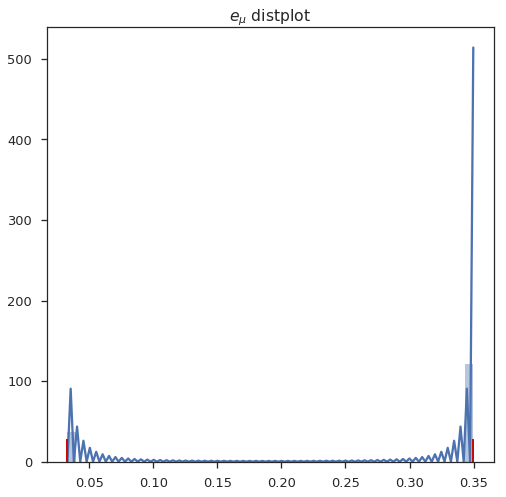

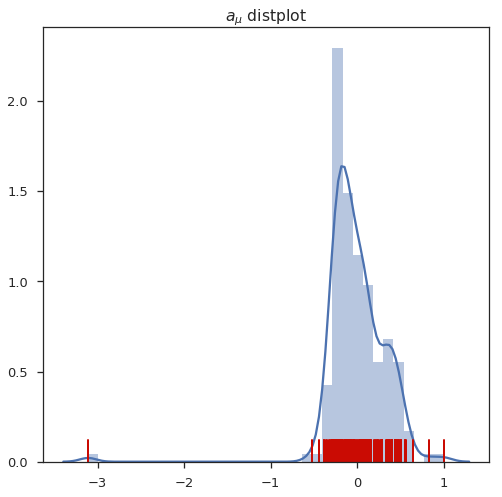

In [16]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3)
evaluate_model(normal_model, X, y, kernel_attrs)